<a href="https://colab.research.google.com/github/Ragdehl/Rakuten_py/blob/main/Livrables/It%C3%A9ration_3/LOOP_3_IMAGES_WITH_EFFICIENT_NET_25_06_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
X = pd.read_csv('X_train_update.csv',index_col=0)
y = pd.read_csv('Y_train_CVw08PX.csv',index_col=0)

In [ ]:
import os #Miscellaneous operating system interfaces
#https://docs.python.org/3/library/os.html

#get current working directory
current_path = os.getcwd() 

#Training images path
images_path = current_path + r'/images2/image_train/'

#List with the name of all training images
images_list = os.listdir(images_path)

In [ ]:
#Create a column with the name of the picture
X['image name'] = 'image_' + X['imageid'].map(str) + '_product_' + X['productid'].map(str) + '.jpg'
X['image name']

0        image_1263597046_product_3804725264.jpg
1         image_1008141237_product_436067568.jpg
2          image_938777978_product_201115110.jpg
3           image_457047496_product_50418756.jpg
4         image_1077757786_product_278535884.jpg
                          ...                   
84911      image_941495734_product_206719094.jpg
84912    image_1188462883_product_3065095706.jpg
84913     image_1009325617_product_440707564.jpg
84914    image_1267353403_product_3942400296.jpg
84915       image_684671297_product_57203227.jpg
Name: image name, Length: 84916, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)

X_val = X_train.iloc[:1600,:]
y_val = y_train.iloc[:1600,:]

X_train = X_train.iloc[:14400,:]
y_train = y_train.iloc[:14400:,:]

X_test = X_test.iloc[:4000,:]
y_test = y_test.iloc[:4000,:]

In [ ]:
X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

In [ ]:
train_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.15,zoom_range = 1.1, horizontal_flip = True)
val_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.15,zoom_range = 1.1,horizontal_flip = True)
test_data_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
batch_size = 32
path = images_path
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)


val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)

Found 14400 validated image filenames belonging to 27 classes.
Found 1600 validated image filenames belonging to 27 classes.
Found 4000 validated image filenames belonging to 27 classes.


In [ ]:
pip install -U efficientnet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import efficientnet.keras as efn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout,Dense, Flatten, GlobalAveragePooling2D

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
opt = Adam(lr=0.0001)

In [ ]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
    
n_class = 27
model = Sequential()
model.add(efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(n_class, activation="sigmoid"))
    
# Compiling the model
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 27)                27675     
Total params: 68,303,543
Trainable params: 68,261,527
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
model.fit_generator(train_generator, 
                                epochs = 2,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data = val_generator,
                                validation_steps = len(X_val)//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
450/450 [==============================] - 1639s 4s/step - loss: 2.9782 - accuracy: 0.1742 - val_loss: 2.5216 - val_accuracy: 0.2862
Epoch 2/2
450/450 [==============================] - 1611s 4s/step - loss: 2.5967 - accuracy: 0.2812 - val_loss: 2.1837 - val_accuracy: 0.3569


In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer= opt , loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
hist_unfreeze = model.fit_generator(generator=train_generator, 
                                epochs = 2,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(X_val)//batch_size
                                )

Epoch 1/2
450/450 [==============================] - 1622s 4s/step - loss: 2.3926 - accuracy: 0.3294 - val_loss: 1.8585 - val_accuracy: 0.4688
Epoch 2/2
450/450 [==============================] - 1678s 4s/step - loss: 2.2835 - accuracy: 0.3477 - val_loss: 1.8688 - val_accuracy: 0.4856


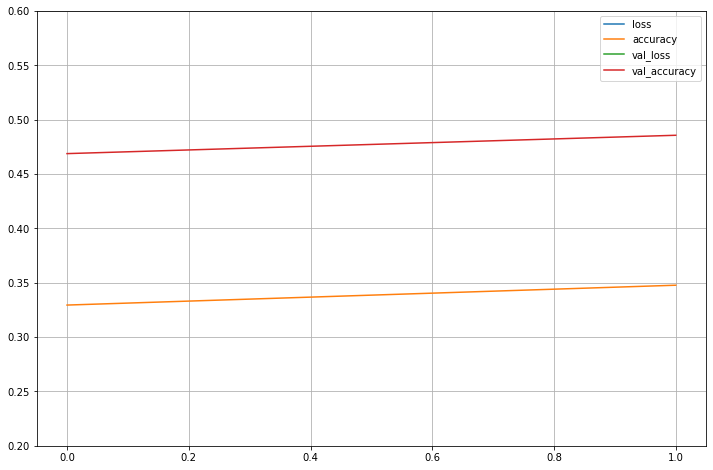

In [ ]:
import pandas as pd
pd.DataFrame(hist_unfreeze.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.6) # set the vertical range to [0-1]
plt.show()

## loop 2 with callbacks + augmentation nombre données (avec passage en batch de 64)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)
X_val = X_train.iloc[:4800,:] #
y_val = y_train.iloc[:4800,:]
X_train = X_train.iloc[:43200,:] #
y_train = y_train.iloc[:43200,:]
X_test = X_test.iloc[:12000,:] #
y_test = y_test.iloc[:12000,:]

In [ ]:
X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

In [ ]:
train_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.12,zoom_range = 1.1, horizontal_flip = True)
val_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.15, height_shift_range = 0.12,zoom_range = 1.1,horizontal_flip = True)
test_data_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
batch_size = 64 #
path = images_path
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)


val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)

Found 43200 validated image filenames belonging to 27 classes.
Found 4800 validated image filenames belonging to 27 classes.
Found 12000 validated image filenames belonging to 27 classes.


In [ ]:
opt2 = Adam(lr=0.1)

In [ ]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
    
n_class = 27
model2 = Sequential()
model2.add(efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'))
model2.add(Flatten())
model2.add(Dense(1024, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(n_class, activation="sigmoid"))
    
# Compiling the model
model2.compile(optimizer=opt2,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten_4 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 27)                27675     
Total params: 68,303,543
Trainable params: 68,261,527
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
# implementation du callback checkpoint
from tensorflow.keras import callbacks
import os
cwd = os.getcwd()
filepath = cwd

checkpoint = callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_loss', save_best_only = True, save_weights_only = False,
                                       mode = 'min', save_freq = 'epoch')

In [ ]:
# diminution du learning rate toutes les epochs
def decreasinglrUpdate(epoch,learning_rate):
    if epoch % 1 == 0:
        return learning_rate * 0.3
    else: 
        return learning_rate
    
lrScheduler = callbacks.LearningRateScheduler(schedule = decreasinglrUpdate,
                                              verbose = 1)

In [ ]:
# Training the model for 10 epochs
history2 = model2.fit_generator(train_generator, 
                                epochs = 7,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data = val_generator,
                                validation_steps = len(X_val)//batch_size,
                                callbacks = [lrScheduler, checkpoint])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.030000000447034835.
Epoch 1/7
675/675 [==============================] - ETA: 0s - loss: 14.5100 - accuracy: 0.0391WARNING:tensorflow:From C:\Users\utilisateur\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\utilisateur\Documents\projet_rakuten\assets
675/675 [==============================] - 4961s 7s/step - loss: 14.5100 - accuracy: 0.0391 - val_loss: 14.6776 - val_accuracy: 0.0360

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009000000357627868.
Epoch 2/7
675/675 [=====

KeyboardInterrupt: 

In [ ]:
# resultats particulièrement mauvais sans amélioration -> arrêt 

In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
model2.compile(optimizer= opt , loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
hist_unfreeze2 = model2.fit_generator(generator=train_generator, 
                                epochs = 5,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(X_val)//batch_size
                                )

In [ ]:
import pandas as pd
pd.DataFrame(history.hist_unfreeze2).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## loop 3 with callbacks + augmentation nombre données (on repart en batch de 32 )
## learning rate fixe

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 123)

X_val = X_train.iloc[:3200,:]
y_val = y_train.iloc[:3200,:]

X_train = X_train.iloc[:28800,:]
y_train = y_train.iloc[:28800:,:]

X_test = X_test.iloc[:8000,:]
y_test = y_test.iloc[:8000,:]

In [ ]:
X_train["class"] = y_train
X_test["class"] = y_test
X_val["class"] = y_val

In [ ]:
train_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.15,zoom_range = 1.1, horizontal_flip = True)
val_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range = 0.15,zoom_range = 1.1,horizontal_flip = True)
test_data_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
batch_size = 32
path = images_path
X_train["class"] = X_train["class"].astype(str)
X_test["class"] = X_test["class"].astype(str)
X_val["class"] = X_val["class"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe=X_train,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)


val_generator = val_data_generator.flow_from_dataframe(dataframe=X_val,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=X_test,
                                                          directory=path,
                                                           x_col = "image name",
                                                           y_col = "class",
                                                           class_mode ="sparse",
                                                          target_size = (224, 224), 
                                                          batch_size = batch_size)

Found 28800 validated image filenames belonging to 27 classes.
Found 3200 validated image filenames belonging to 27 classes.
Found 8000 validated image filenames belonging to 27 classes.


In [ ]:
opt3 = Adam(lr=0.0001)

In [ ]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
    
n_class = 27
model3 = Sequential()
model3.add(efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet'))
model3.add(Flatten())
model3.add(Dense(1024, activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(n_class, activation="sigmoid"))
    
# Compiling the model
model3.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten_5 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              64226304  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 27)                27675     
Total params: 68,303,543
Trainable params: 68,261,527
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
# implementation du callback checkpoint
from tensorflow.keras import callbacks
import os
cwd = os.getcwd()
filepath = cwd

checkpoint = callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_loss', save_best_only = True, save_weights_only = False,
                                       mode = 'min', save_freq = 'epoch')

In [ ]:
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=2, mode='min')

In [ ]:
# Training the model for 3 epochs
history3 = model3.fit_generator(train_generator, 
                                epochs = 3,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data = val_generator,
                                validation_steps = len(X_val)//batch_size,
                                callbacks = [lr_plateau , checkpoint])

Epoch 1/3
900/900 [==============================] - 3369s 4s/step - loss: 3.1619 - accuracy: 0.0974 - val_loss: 2.8459 - val_accuracy: 0.1728
Epoch 2/3
900/900 [==============================] - 4129s 5s/step - loss: 2.7323 - accuracy: 0.2122 - val_loss: 2.3597 - val_accuracy: 0.3300
Epoch 3/3
900/900 [==============================] - 4154s 5s/step - loss: 2.4262 - accuracy: 0.3099 - val_loss: 2.0863 - val_accuracy: 0.3837


In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [ ]:
model3.compile(optimizer= opt , loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
hist_unfreeze3 = model3.fit_generator(generator=train_generator, 
                                epochs = 3,
                                steps_per_epoch = len(X_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(X_val)//batch_size
                                )

Epoch 1/3
900/900 [==============================] - 3672s 4s/step - loss: 2.2580 - accuracy: 0.3553 - val_loss: 1.8056 - val_accuracy: 0.4775
Epoch 2/3
900/900 [==============================] - 3648s 4s/step - loss: 2.1416 - accuracy: 0.3816 - val_loss: 1.7165 - val_accuracy: 0.5200
Epoch 3/3
900/900 [==============================] - 5692s 6s/step - loss: 2.0611 - accuracy: 0.4059 - val_loss: 1.6005 - val_accuracy: 0.5391


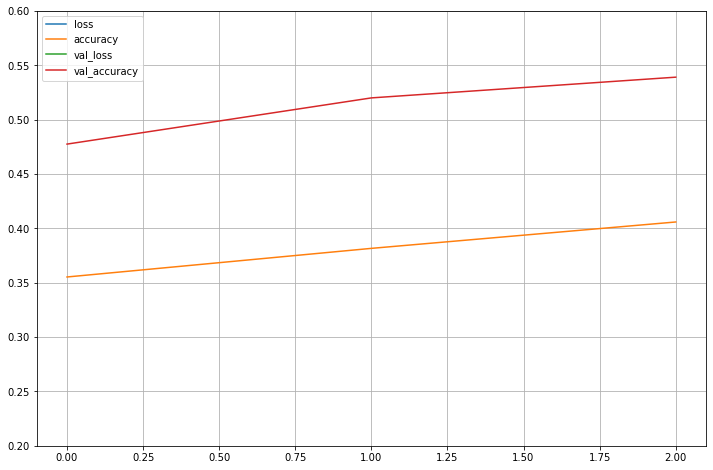

In [ ]:
import pandas as pd
pd.DataFrame(hist_unfreeze3.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.6) # set the vertical range to [0-1]
plt.show()